<a href="https://colab.research.google.com/github/jumbokh/ML-Class/blob/main/notebook/Ch9_4_Features-eng.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 前置作業

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rcParams['font.sans-serif'] = ['DFKai-sb'] 
plt.rcParams['axes.unicode_minus'] = False
%config InlineBackend.figure_format = 'retina'
import warnings
warnings.filterwarnings('ignore')

# 資料載入
df = pd.read_csv('titanic_train.csv')
df = df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)
# 欄位設定
X_col_num = ['Age', 'SibSp', 'Parch', 'Fare']
X_col_cat = ['Pclass', 'Sex', 'Embarked']
X_cols = X_col_num + X_col_cat
y_col = 'Survived'
# 資料切割成訓練和測試集
from sklearn.model_selection import train_test_split
X = df[X_cols]
y = df[y_col]
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                   test_size=0.33, random_state=42)

In [2]:
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
num_pl = make_pipeline(
    SimpleImputer(strategy='median')
)
cat_pl = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder(sparse=False)
)
data_pl = ColumnTransformer([
    ('num_pl', num_pl, X_col_num),
    ('cat_pl', cat_pl, X_col_cat)    
])

In [3]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
model_pl_tree = make_pipeline(data_pl, 
                              DecisionTreeClassifier(random_state=42))
model_pl_tree.fit(X_train, y_train)
y_pred = model_pl_tree.predict(X_train)
print('正確率：', accuracy_score(y_train, y_pred).round(2))
print('混亂矩陣')
print(confusion_matrix(y_train, y_pred))

正確率： 0.98
混亂矩陣
[[373   1]
 [ 11 211]]


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


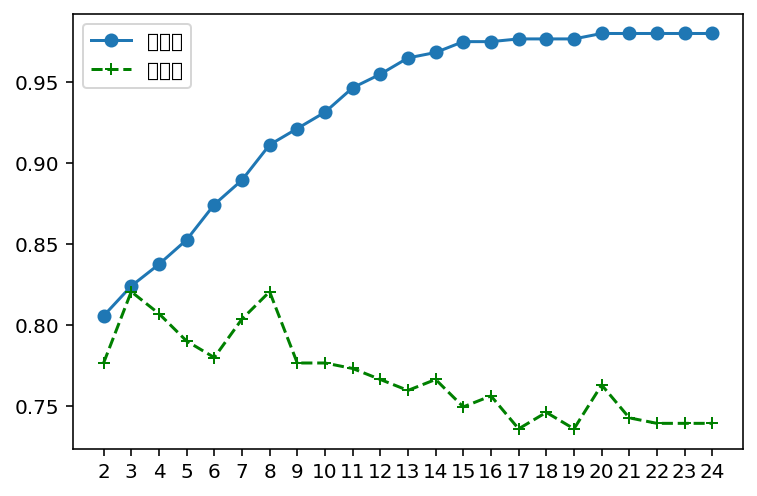

In [4]:
acc_train = []
acc_test = []
n_depth = range(2,25)
for n in n_depth:
    model_pl_tree = make_pipeline(
        data_pl, 
        DecisionTreeClassifier(max_depth=n, random_state=42)
    )
    model_pl_tree.fit(X_train, y_train)
    acc_train.append(model_pl_tree.score(X_train, y_train))
    acc_test.append(model_pl_tree.score(X_test, y_test))
# 繪圖開始
plt.rcParams['font.sans-serif'] = ['Taipei Sans TC Beta']
plt.plot(n_depth, acc_train, marker='o', label='訓練集')
plt.plot(n_depth, acc_test, c='green', 
         marker='+', ls='--', label='測試集')
plt.xticks(n_depth, n_depth)
plt.legend();

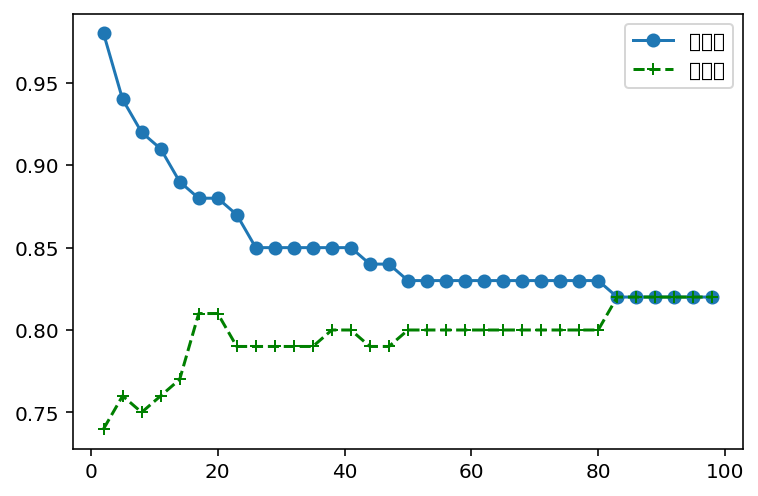

In [5]:
acc_train = []
acc_test = []
n_range = range(2,100,3)
for n in n_range:
    model_pl_tree = make_pipeline(data_pl, 
                                  DecisionTreeClassifier(random_state=42, min_samples_split=n))
    model_pl_tree.fit(X_train, y_train)
    acc_train.append(model_pl_tree.score(X_train, y_train).round(2))
    acc_test.append(model_pl_tree.score(X_test, y_test).round(2))
plt.rcParams['font.sans-serif'] = ['Taipei Sans TC Beta']
plt.plot(n_range, acc_train, marker='o', label='訓練集')
plt.plot(n_range, acc_test, c='green', marker='+', ls='--', label='測試集')
plt.legend();

### 探索特徵值

#### 用決策樹了解那些特徵值是重要的

In [6]:
model_pl_tree = make_pipeline(
    data_pl, 
    DecisionTreeClassifier(max_depth=4, random_state=42)
)
model_pl_tree.fit(X_train, y_train)
tree = model_pl_tree.named_steps['decisiontreeclassifier']
feature_importance = tree.feature_importances_.round(3)
feature_importance

array([0.099, 0.043, 0.   , 0.093, 0.   , 0.   , 0.185, 0.561, 0.   ,
       0.   , 0.   , 0.019])

In [7]:
print(f'數值型特徵值{X_col_num}')
print(f'類別型特徵值{X_col_cat}')
cat_pl = data_pl.named_transformers_['cat_pl']
oh_cols = cat_pl.named_steps['onehotencoder'].\
get_feature_names(X_col_cat)
print(f'獨熱編碼後的特徵值。{oh_cols}')
cols = X_col_num + oh_cols.tolist()
print(f'所有欄位{cols}')

數值型特徵值['Age', 'SibSp', 'Parch', 'Fare']
類別型特徵值['Pclass', 'Sex', 'Embarked']
獨熱編碼後的特徵值。['Pclass_1' 'Pclass_2' 'Pclass_3' 'Sex_female' 'Sex_male' 'Embarked_C'
 'Embarked_Q' 'Embarked_S']
所有欄位['Age', 'SibSp', 'Parch', 'Fare', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S']


In [8]:
pd.DataFrame(feature_importance, index=cols, columns=['係數']).\
sort_values(by='係數', ascending=False)

,係數
Sex_female,0.561
Pclass_3,0.185
Age,0.099
Fare,0.093
SibSp,0.043
Embarked_S,0.019
Parch,0.000
Pclass_1,0.000
Pclass_2,0.000
Sex_male,0.000


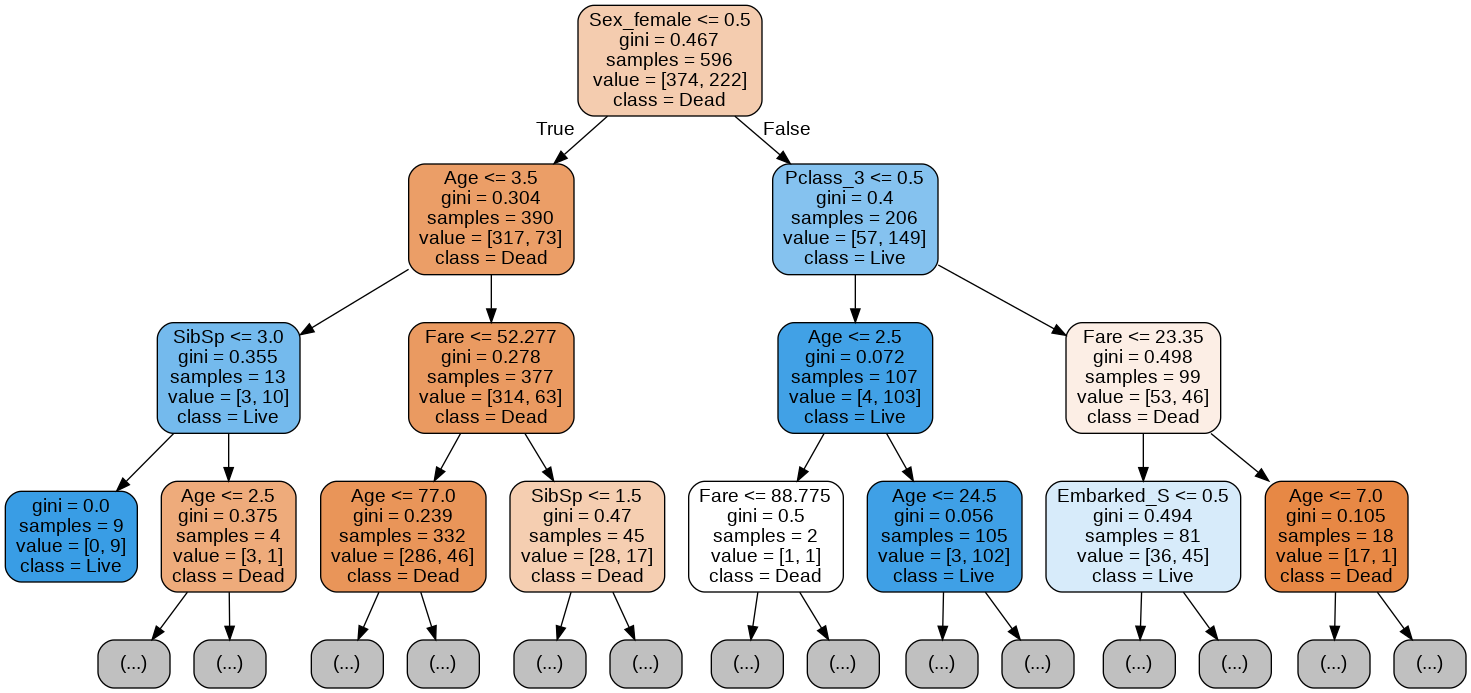

In [10]:
from sklearn.tree import export_graphviz
import pydot 
from IPython.display import Image  
# features變數存放所有欄位名稱
features = cols
# class_names變數存放目標值表呈現的文字意義
class_names = ['Dead', 'Live']
# export_graphviz的第一個參數是決策樹模型的預測結果
# max_depth=3可設定決策樹呈現的深度，其餘參數讀者可自己測試
dot_data = export_graphviz(
    model_pl_tree.named_steps['decisiontreeclassifier'], 
    out_file=None,
    feature_names=features,
    class_names = class_names,
    proportion = False,
    max_depth=3,
    filled=True,
    rounded=True
)
graph = pydot.graph_from_dot_data(dot_data)  
# 也將結果存到tree.png檔案裡
graph[0].write_png('tree.png')
Image(graph[0].create_png())